# 2.6 手写数字识别之优化算法

**第2.5节**我们明确了分类任务的损失函数（优化目标）的相关概念和实现方法，本节我们依旧横向展开"横纵式"教学法，如 **图1** 所示，本节主要探讨在手写数字识别任务中，使得损失达到最小的参数取值的实现方法。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/81405034cc7c4315b33d2aae990edc8013626c7dcdd54d56bc9afce9127c9be0" width="1000" hegiht="" ></center>
<center>图1：“横纵式”教学法 — 优化算法</center>
<br></br>

**前提条件**

在优化算法之前，需要进行数据处理、设计神经网络结构，代码与上一节保持一致，此处直接调用封装好的代码。

In [1]:
import paddle
from data_process import get_MNIST_dataloader
from MNIST_network import MNIST

train_loader, test_loader = get_MNIST_dataloader()

## 2.6.1 学习率

在深度学习神经网络模型中，通常使用标准的随机梯度下降算法更新参数，学习率代表参数更新幅度的大小，即步长。当学习率最优时，模型的有效容量最大，最终能达到的效果最好。学习率和深度学习任务类型有关，合适的学习率往往需要大量的实验和调参经验。探索学习率最优值时需要注意如下两点：

- **学习率不是越小越好**。学习率越小，损失函数的变化速度越慢，意味着我们需要花费更长的时间进行收敛，如 **图2** 左图所示。
- **学习率不是越大越好**。只根据总样本集中的一个批次计算梯度，抽样误差会导致计算出的梯度不是全局最优的方向，且存在波动。在接近最优解时，过大的学习率会导致参数在最优解附近震荡，损失难以收敛，如 **图2** 右图所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1e0f066dc9fa4e2bbc942447bdc0578c2ffc6afc15684154ae84bcf31b298d7b" width="500" hegiht="" ></center>
<center><br>图2: 不同学习率（步长过大/过小）的示意图</br></center>
<br></br>

在训练前，我们往往不清楚一个特定问题设置成怎样的学习率是合理的，因此在训练时可以尝试调小或调大，通过观察Loss下降的情况判断合理的学习率，设置学习率的代码如下所示。

In [2]:
import paddle.nn.functional as F

#仅优化算法的设置有所差别
def train(model):
    model.train()
    
    #设置不同初始学习率
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    # opt = paddle.optimizer.SGD(learning_rate=0.0001, parameters=model.parameters())
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 10
    loss_list = []
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, loss))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
   
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return loss_list
    
#创建模型    
model = MNIST()
#启动训练过程
loss_list = train(model)

W0902 13:59:43.727392    98 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0902 13:59:43.731014    98 device_context.cc:465] device: 0, cuDNN Version: 7.6.


epoch: 0, batch: 0, loss is: 2.672663927078247
epoch: 0, batch: 200, loss is: 1.5871143341064453
epoch: 0, batch: 400, loss is: 0.8906817436218262
epoch: 0, batch: 600, loss is: 0.8545184135437012
epoch: 0, batch: 800, loss is: 0.5248807668685913
epoch: 1, batch: 0, loss is: 0.4951104521751404
epoch: 1, batch: 200, loss is: 0.3496471643447876
epoch: 1, batch: 400, loss is: 0.49374574422836304
epoch: 1, batch: 600, loss is: 0.5409931540489197
epoch: 1, batch: 800, loss is: 0.45909279584884644
epoch: 2, batch: 0, loss is: 0.31246766448020935
epoch: 2, batch: 200, loss is: 0.3619728684425354
epoch: 2, batch: 400, loss is: 0.172702357172966
epoch: 2, batch: 600, loss is: 0.2503175139427185
epoch: 2, batch: 800, loss is: 0.2594001591205597
epoch: 3, batch: 0, loss is: 0.18350714445114136
epoch: 3, batch: 200, loss is: 0.31369107961654663
epoch: 3, batch: 400, loss is: 0.24545088410377502
epoch: 3, batch: 600, loss is: 0.22522735595703125
epoch: 3, batch: 800, loss is: 0.20448797941207886
ep

绘制loss变化曲线：

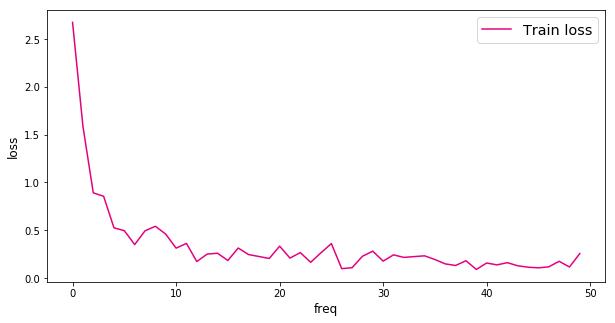

In [4]:
from tools import plot

plot(loss_list)


##  2.6.2 学习率的四种主流优化算法

学习率是优化器的一个参数，调整学习率看似是一件非常麻烦的事情，需要不断的调整步长，观察训练时间和Loss的变化。经过科研人员的不断的实验，当前已经形成了四种比较成熟的优化算法：SGD、Momentum、AdaGrad和Adam，效果如 **图3** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/f4cf80f95424411a85ad74998433317e721f56ddb4f64e6f8a28a27b6a1baa6b" width="800" hegiht="" ></center>
<center><br>图3: 不同学习率算法效果示意图</br></center>
<br></br>

* **[SGD：](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/optimizer/SGD_cn.html)** 随机梯度下降算法，每次训练少量数据，抽样偏差导致的参数收敛过程中震荡。

* **[Momentum：](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/optimizer/Momentum_cn.html)** 引入物理“动量”的概念，累积速度，减少震荡，使参数更新的方向更稳定。

每个批次的数据含有抽样误差，导致梯度更新的方向波动较大。如果我们引入物理动量的概念，给梯度下降的过程加入一定的“惯性”累积，就可以减少更新路径上的震荡，即每次更新的梯度由“历史多次梯度的累积方向”和“当次梯度”加权相加得到。历史多次梯度的累积方向往往是从全局视角更正确的方向，这与“惯性”的物理概念很像，也是为何其起名为“Momentum”的原因。类似不同品牌和材质的篮球有一定的重量差别，街头篮球队中的投手（擅长中远距离投篮）往往更喜欢稍重篮球。一个很重要的原因是，重的篮球惯性大，更不容易受到手势的小幅变形或风吹的影响。

* **[AdaGrad：](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/optimizer/AdagradOptimizer_cn.html)** 根据不同参数距离最优解的远近，动态调整学习率。学习率逐渐下降，依据各参数变化大小调整学习率。

通过调整学习率的实验可以发现：当某个参数的现值距离最优解较远时（表现为梯度的绝对值较大），我们期望参数更新的步长大一些，以便更快收敛到最优解。当某个参数的现值距离最优解较近时（表现为梯度的绝对值较小），我们期望参数的更新步长小一些，以便更精细的逼近最优解。类似于打高尔夫球，专业运动员第一杆开球时，通常会大力打一个远球，让球尽量落在洞口附近。当第二杆面对离洞口较近的球时，他会更轻柔而细致的推杆，避免将球打飞。与此类似，参数更新的步长应该随着优化过程逐渐减少，减少的程度与当前梯度的大小有关。根据这个思想编写的优化算法称为“AdaGrad”，Ada是Adaptive的缩写，表示“适应环境而变化”的意思。[RMSProp](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/optimizer_cn/RMSPropOptimizer_cn.html#rmspropoptimizer)是在AdaGrad基础上的改进，学习率随着梯度变化而适应，解决AdaGrad学习率急剧下降的问题。

* **[Adam：](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/optimizer/Adam_cn.html)**  由于动量和自适应学习率两个优化思路是正交的，因此可以将两个思路结合起来，这是当前广泛应用的算法。



------
**说明：**

每种优化算法均有更多的参数设置，详情可查阅[飞桨的官方API文档](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/index_cn.html)。理论最合理的未必在具体案例中最有效，所以模型调参是很有必要的，最优的模型配置往往是在一定“理论”和“经验”的指导下实验出来的。

------

我们可以尝试选择不同的优化算法训练模型，观察训练时间和损失变化的情况，代码实现如下。

In [5]:
#仅优化算法的设置有所差别
def train(model):
    model.train()
    
    #四种优化算法的设置方案，可以逐一尝试效果
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 3
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
#创建模型    
model = MNIST()
#启动训练过程
train(model)

epoch: 0, batch: 0, loss is: [3.179514]
epoch: 0, batch: 200, loss is: [0.41207898]
epoch: 0, batch: 400, loss is: [0.14528263]
epoch: 0, batch: 600, loss is: [0.17151298]
epoch: 0, batch: 800, loss is: [0.20650986]
epoch: 1, batch: 0, loss is: [0.048602]
epoch: 1, batch: 200, loss is: [0.16017383]
epoch: 1, batch: 400, loss is: [0.09366961]
epoch: 1, batch: 600, loss is: [0.20587194]
epoch: 1, batch: 800, loss is: [0.03139528]
epoch: 2, batch: 0, loss is: [0.07924803]
epoch: 2, batch: 200, loss is: [0.03837227]
epoch: 2, batch: 400, loss is: [0.20707312]
epoch: 2, batch: 600, loss is: [0.05167127]
epoch: 2, batch: 800, loss is: [0.0629859]


## 2.6.3 模型参数初始化

模型参数初始化是指在训练前，给要训练的参数一个初始的值。比如我们最终的目的是走到山谷底，如果一开始把你放到半山腰和放到山脚，那是否能够顺利走到谷底以及走到谷底的速度是有很大差距的。同样，在我们训练神经网络的时候，训练参数初始值不同也会导致模型收敛速度和最终训练效果的不同。

在PaddlePaddle框架中，MNIST模型中用到的`Conv2D`和`Linear`层都有`weight_attr`和`bias_attr`两个参数，默认为`None`，表示使用默认的权重参数属性。这两个参数可以使用模型的named_parameters()函数获得。

通过下面的代码我们可以查看模型每层的参数情况：

> 模型的state_dict函数可获取当前层及其子层的所有参数和可持久性buffers。并将所有参数和buffers存放在dict结构中。

In [6]:
model = MNIST()

# 遍历所有的参数名和参数值
for name, param in model.named_parameters():
    print(name, param)  
    
state_dict = model.state_dict() #collections.OrderedDict类型

print(state_dict.keys())

# 根据某个参数的名字，打印对应的参数值
# 如打印“conv1.weight”的参数值
print("conv1.weight:",state_dict["conv1.weight"])

conv1.weight Parameter containing:
Tensor(shape=[20, 1, 5, 5], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[[[ 0.00685916, -0.02827659, -0.00629800,  0.17840426,  0.07073421],
          [ 0.15301149,  0.14512494, -0.08644208, -0.04089865,  0.06347622],
          [-0.17223580,  0.53609502, -0.31562763,  0.31539580,  0.11763398],
          [ 0.06057844,  0.12100003, -0.19036214, -0.32686502, -0.04253779],
          [-0.24231870, -0.09162699, -0.00356645,  0.13624071,  0.35424659]]],


        [[[ 0.19513041, -0.18949197, -0.06306379, -0.33953783, -0.12144631],
          [-0.52912796, -0.04904719,  0.22196575, -0.21367665, -0.14066246],
          [-0.47838733,  0.19762798,  0.32846957, -0.06876396, -0.05648636],
          [-0.49627945,  0.04398900, -0.02770269, -0.09062629, -0.25601473],
          [ 0.22629717,  0.12104782, -0.21879482, -0.29909152,  0.15422553]]],


        [[[-0.57517582,  0.07872081,  0.24480270, -0.10398132, -0.21764469],
          [-0.15390907,  0

通过`print(state_dict.keys())`打印的结果为`['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc.weight', 'fc.bias']`，对应我们模型结构：两个卷积层，一个全连接层。每一层都有一个权重项和偏置项。由于有两个卷积层，所以卷积的权重名称有对应的编号。

[paddle.ParamAttr](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/ParamAttr_cn.html#cn-api-fluid-paramattr)可创建一个参数属性的对象，用户可设置参数的名称`name`、初始化方式`initializer`、学习率`learning_rate`、正则化规则`regularizer`、是否需要训练`trainable`、梯度裁剪方式`need_clip`、是否做模型平均`do_model_average`等属性。其参数初始化方式`initializer`默认值为`None`，表示权重参数采用Xavier初始化方式，偏置参数采用全0初始化方式。Xavier初始化方式可以缓解梯度消失的问题。

下面简单介绍几个常用的权重初始化方法：
* [XavierUniform](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/initializer/XavierUniform_cn.html#xavieruniform)、[XavierNormal](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/initializer/XavierNormal_cn.html)初始化函数用于保持所有层的梯度尺度几乎一致。
* [Constant](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/initializer/Constant_cn.html)为常量初始化函数，用于权重初始化，通过输入的value值初始化输入变量。
* [KaimingNormal](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/initializer/KaimingNormal_cn.html)、[KaimingUniform](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/initializer/KaimingUniform_cn.html)方法来自Kaiming He，Xiangyu Zhang，Shaoqing Ren 和 Jian Sun所写的论文: [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)。这是一个鲁棒性特别强的初始化方法，并且适应了非线性激活函数（rectifier nonlinearities）。
* [Normal](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/initializer/Normal_cn.html)随机正态（高斯）分布初始化函数。

下面我们通过`paddle.ParamAttr`基于常量初始化函数`Constant`完成全连接层的参数初始化，具体如下：

In [7]:
import paddle
from paddle.nn import Linear

weight_attr = paddle.ParamAttr(initializer=paddle.nn.initializer.Constant(3))
#weight_attr = paddle.ParamAttr(initializer=paddle.nn.initializer.XavierNormal())

fc = Linear(in_features=20, out_features=10,weight_attr=weight_attr)

print(fc.state_dict())

OrderedDict([('weight', Parameter containing:
Tensor(shape=[20, 10], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [3., 3., 3., 3., 

**在我们的实际应用中，由于训练数据有限、数据获取较难、训练资源有限等原因，往往利用在大规模开源数据集上训练得到的模型参数作为我们自己模型的初始值（也称为预训练模型），这样可以加速网络训练、并得到较高精度。**

## 作业 2-3

在手写数字识别任务上，哪种优化算法的效果最好？多大的学习率最优？（可通过Loss的下降趋势来判断）
